# Chest X-Ray Normal(not pneumonia) and pneumonia disease imgage Classification

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import cv2
import matplotlib.pyplot as plt

# Dl framwork - tensorflow, keras a backend 
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization 
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from os import listdir
from os.path import isfile, join
from PIL import Image
import glob


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
dir_name = '/kaggle/input/'
# for dirname, _, filenames in os.walk(dir_name):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
    
# Any results you write to the current directory are saved as output.

In [2]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56}, log_device_placement=True ) 
sess = tf.compat.v1.Session(config=config) 

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



The dataset respective to already classified category is divided into three sets: 
1. train set ,
1. validation set and 
1. test set. 

In [3]:
# Input data file
train_path = os.path.join(dir_name, 'chest-xray-pneumonia/chest_xray/train')
train_normal_path = os.path.join(train_path, 'NORMAL')
train_pneumonia_path = os.path.join(train_path, 'PNEUMONIA')

val_path = os.path.join(dir_name, 'chest-xray-pneumonia/chest_xray/test')
val_normal_path = os.path.join(val_path, 'NORMAL')
val_pneumonia_path = os.path.join(val_path, 'PNEUMONIA')

test_path = os.path.join(dir_name, 'chest-xray-pneumonia/chest_xray/test')
test_normal_path = os.path.join(test_path, 'NORMAL')
test_pneumonia_path = os.path.join(test_path, 'PNEUMONIA')

In [4]:
# # Plot the Images:
def plot_images(item_dir, n=6):
    all_item_dir = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dir][:n]
    
    plt.figure(figsize=(35, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(2, n, idx+1)
        img = plt.imread(img_path)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()

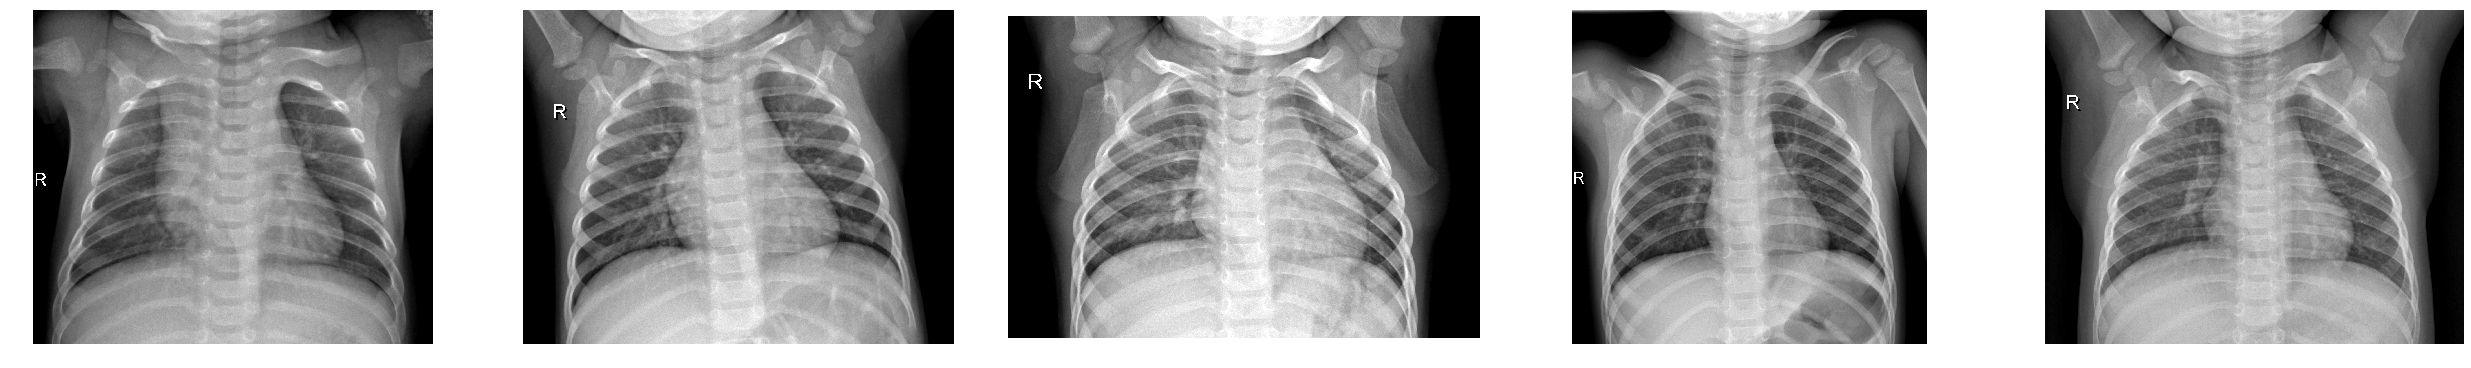

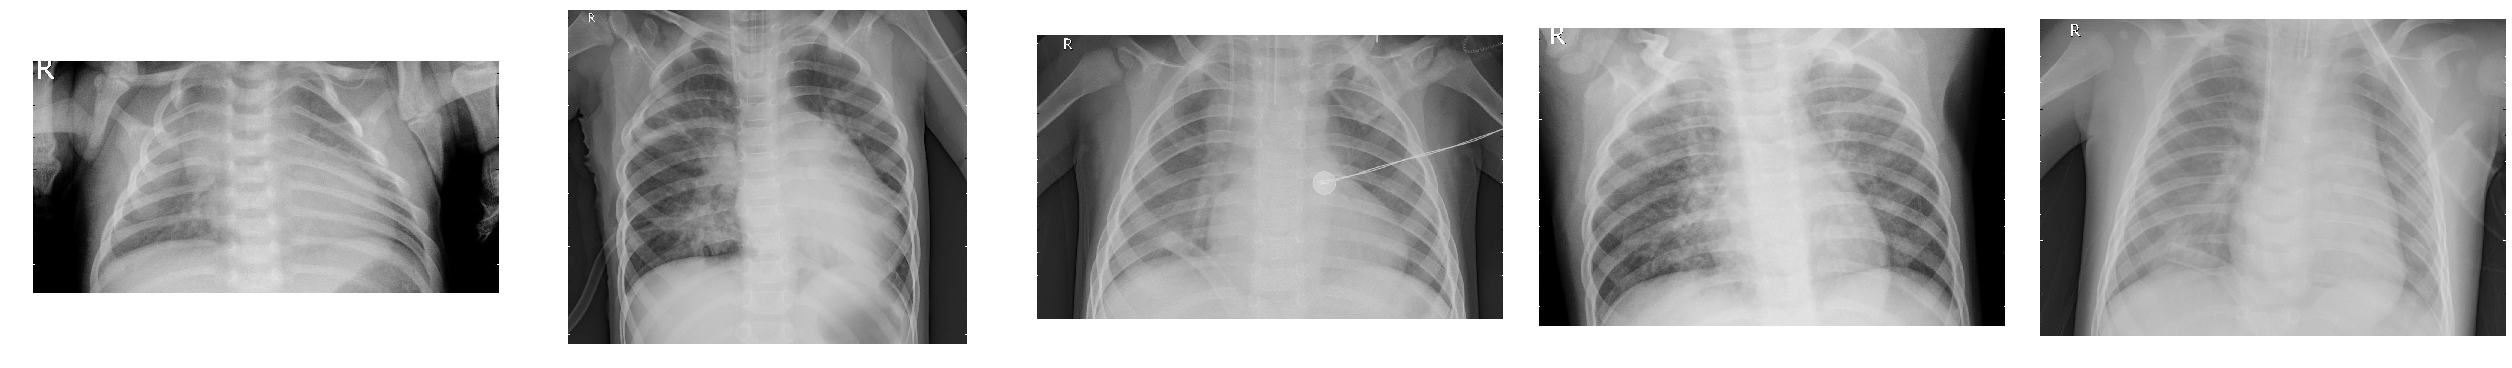

In [5]:
plot_images(train_normal_path, 5)
plot_images(train_pneumonia_path, 5)

In [6]:
def Images_details_Print_data(data, path):
    print(" ====== Images in: ", path)    
    for k, v in data.items():
        print("%s:\t%s" % (k, v))

def Images_details(path):
    files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100  # No image will be bigger than that
    data['max_width'] = 0
    data['min_height'] = 10**100  # No image will be bigger than that
    data['max_height'] = 0


    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['max_width'] = max(width, data['max_height'])
        data['min_height'] = min(height, data['min_height'])
        data['max_height'] = max(height, data['max_height'])

    Images_details_Print_data(data, path)

In [7]:
Images_details(train_normal_path)
Images_details(train_pneumonia_path)

 ====== Images in:  /kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL
images_count:	1341
min_width:	912
max_width:	2663
min_height:	672
max_height:	2663
 ====== Images in:  /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA
images_count:	3875
min_width:	384
max_width:	2304
min_height:	127
max_height:	2304


In [8]:
input_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/"
    
for _set in ['train', 'test', 'val']:
    nrml = len(os.listdir(input_path + _set + '/NORMAL'))
    pnm = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('{}, Normal images: {}, Pneumonia images: {}'.format(_set, nrml, pnm))

train, Normal images: 1342, Pneumonia images: 3876
test, Normal images: 234, Pneumonia images: 390
val, Normal images: 9, Pneumonia images: 9


### Data Augmentation
The practice of data augmentation is an effective way to increase the size of the training set.

Augmenting the training examples allow the network to “see” more diversified, but still representative, data points during training.

There's two data generators: one for training data, and the other for validation data. A data generator is capable of loading the required amount of data (a mini batch of images) directly from the source folder, convert them into training data (fed to the model) and training targets (a vector of attributes — the supervision signal).

In [9]:

def process_data(img_dims, batch_size):
    # Data generation objects - thorugh rescalling, veticle flip, zoom range
    train_datagen = ImageDataGenerator(
                        rescale = 1./255,
                      # featurewise_center=True,
                      # featurewise_std_normalization=True,
                        zoom_range = 0.3,
                        vertical_flip = True)
    
    test_datagen = ImageDataGenerator(
                      #  featurewise_center=True,
                      #  featurewise_std_normalization=True,
                        rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
                                directory = train_path, 
                                target_size = (img_dims, img_dims), 
                                batch_size = batch_size, 
                                class_mode = 'binary', 
                                shuffle=True)

    test_gen = test_datagen.flow_from_directory(
                                directory=test_path, 
                                target_size=(img_dims, img_dims), 
                                batch_size=batch_size, 
                                class_mode='binary', 
                                shuffle=True)
    
    # Making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(test_path + cond)):
            img = plt.imread(test_path + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [10]:
# Hyperparameters
img_dims = 150
epochs = 20
batch_size = 32

# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model

In this approach, I tried to trained the modal from scratch. The process I followed is - 

1. Selected a simple architecture.
1. Initialized the layers from given training data with dims 150. 
1. Choose layers that introduce a lesser number of parameters. For example, [Depthwise SeparableConv](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728) is a good replacement for `Conv layer`. It introduces lesser number of parameters as compared to normal convolution and as different filters are applied to each channel, so it captures more information. 
1. Used batch norm with convolutions. As the network becomes deeper, batch norm start to play an important role.
1. Added dense layers with reasonable amount of neurons. Trained with a higher learning rate and experiment with the number of neurons in the dense layers. Did it for the depth of your network too.
1. Once a good depth, started training the network with a lower learning rate.

Ref: https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

In [11]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128   

In [13]:
#### Fitting the model
history = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size,
           callbacks=[checkpoint, lr_reduce])

Train for 163 steps, validate for 19 steps
Epoch 1/20
163/163 [==============================] - 104s 637ms/step - loss: 0.3726 - accuracy: 0.8294 - val_loss: 0.7103 - val_accuracy: 0.6234
Epoch 2/20
163/163 [==============================] - 98s 601ms/step - loss: 0.2694 - accuracy: 0.8942 - val_loss: 0.8314 - val_accuracy: 0.6234
Epoch 3/20
163/163 [==============================] - 100s 613ms/step - loss: 0.2403 - accuracy: 0.9099 - val_loss: 1.5699 - val_accuracy: 0.6234
Epoch 4/20
163/163 [==============================] - 99s 606ms/step - loss: 0.2261 - accuracy: 0.9080 - val_loss: 0.6317 - val_accuracy: 0.6266
Epoch 5/20
163/163 [==============================] - 98s 601ms/step - loss: 0.1977 - accuracy: 0.9239 - val_loss: 3.5893 - val_accuracy: 0.6234
Epoch 6/20
163/163 [==============================] - 99s 606ms/step - loss: 0.1929 - accuracy: 0.9245 - val_loss: 0.3693 - val_accuracy: 0.8438
Epoch 7/20
162/163 [============================>.] - ETA: 0s - loss: 0.1840 - accura

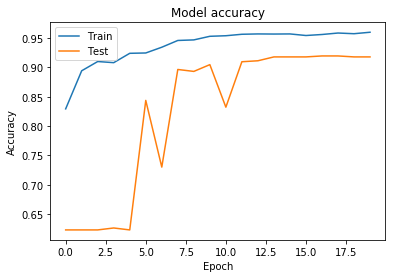

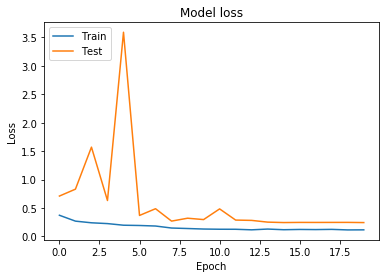

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

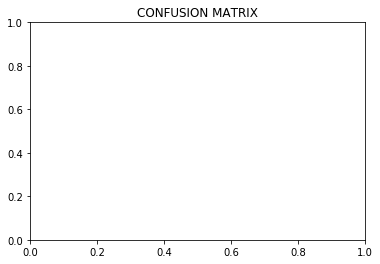

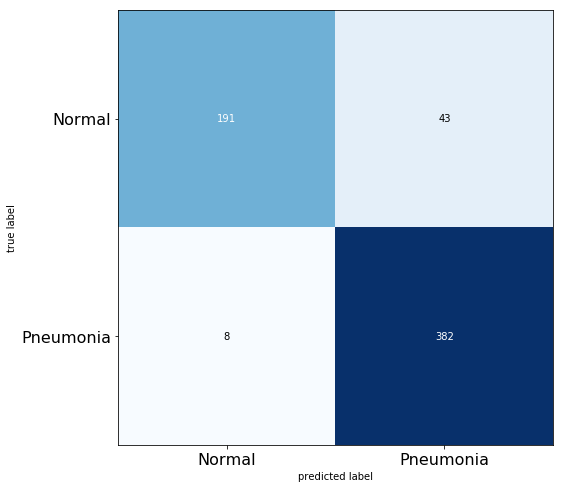

In [15]:
# confution matrix
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

preds = model.predict(test_data)

accuracy = accuracy_score(test_labels, np.round(preds))*100
conf_mat = confusion_matrix(test_labels, np.round(preds))
true_negative, false_postive, false_negative, true_posiitve = conf_mat.ravel()

plot_confusion_matrix(conf_mat,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [16]:
print('\n','-'*20,' TEST METRICS', '-'*20)
precision = true_posiitve / (true_posiitve + false_postive) * 100
recall = true_posiitve / (true_posiitve + false_negative) * 100
print('\tAccuracy: {}%'.format(accuracy))
print('\tPrecision: {}%'.format(precision))
print('\tRecall: {}%'.format(recall))
print('\tF1-score: {}'.format(2*precision*recall/(precision+recall)))


 --------------------  TEST METRICS --------------------
	Accuracy: 91.82692307692307%
	Precision: 89.88235294117646%
	Recall: 97.94871794871794%
	F1-score: 93.74233128834354


In [17]:
# Save the model
model.save('xray-pneumona-depthwise-convolution.h5')

The model is converging which can be observed from the decrease in loss and validation loss with epochs. Also it is able to reach over 90% validation accuracy in just 20 epochs, which is good.

The classes are imbalanced therefore validation accuracy won't be a good metric to analyze the model performance. The other metric, recall, precison and confusion matrix is good alternative to see the performance of the model. In this model, we got almost 98% recall value and 90% precison which is pretty good.

Also, here recall is most significant quantity even more than accuracy and precision because in this dataset we have to minimize the false negative as low as possible

False negative has to be intuitively minimized because falsely diagnosing a patient of pneumonia as not having a pneumonia is a much larger deal than falsely diagnosing a healthy person as a pneumonia patient which is our major concern . That is why we are making this model. To reduce the mistakes done by doctors accidentally. 